In [2]:
%pwd

'/home/xupb/scRNA_data/mouse_pfc/manuscripts/scanpy'

In [3]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as pl
#from matplotlib import rcParams
import scanpy as sc
import loompy
print(loompy.__version__)
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

/home/xupb/anaconda3/envs/myenv/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


3.0.6


In [4]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.0 scipy==1.3.0 pandas==0.23.4 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [5]:
sc.settings.set_figure_params(dpi=80, frameon=False,fontsize=20,dpi_save=300,format='pdf')  # low dpi (dots per inch) yields small inline figures
plt.rcParams['font.sans-serif']=['Arial']
plt.rcParams['pdf.fonttype'] = 'truetype'

# import loom file

In [5]:
## read loom file for first time, next time, load h5ad file

#adata=sc.read_loom('/home/xupb/scRNA_data/mouse_pfc/manuscripts/pfc_seu_merge_loom_bar5.loom')

/home/xupb/anaconda3/envs/myenv/lib/python3.7/site-packages/loompy/loom_layer.py:123: RuntimeWarning: invalid value encountered in not_equal
  nonzeros = np.where(vals != 0)


In [20]:
adata

AnnData object with n_obs × n_vars = 21261 × 20595 
    obs: 'ClusterID', 'ClusterName', 'facs', 'nCount_RNA', 'nFeature_RNA', 'orig_ident', 'percent_mt', 'percent_rp', 'sample', 'louvain', 'leiden'
    var: 'Selected', 'vst_mean', 'vst_variable', 'vst_variance', 'vst_variance_expected', 'vst_variance_standardized', 'highly_variable'
    uns: 'neighbors', 'louvain', 'umap', 'louvain_colors', 'facs_colors', 'leiden', 'leiden_colors'
    obsm: 'pca_cell_embeddings', 'X_pca', 'X_umap'
    varm: 'pca_feature_loadings'
    layers: 'norm_data', 'scale_data'

# import PCs and HVGs

In [7]:
adata.obsm['X_pca']=adata.obsm['pca_cell_embeddings']

In [9]:
adata.var['highly_variable']=adata.var['Selected'].astype('bool')

In [13]:
results_file = './write/pfc_seurat_merge.h5ad'
adata.write(results_file) 

In [ ]:
adata=sc.read_h5ad('./write/pfc_seurat_merge.h5ad')

# Run umap and leiden cluster

In [31]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)


In [32]:
sc.tl.leiden(adata,resolution =0.1)
sc.tl.umap(adata)

running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
computing UMAP


/home/xupb/anaconda3/envs/myenv/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)


In [58]:
sc.tl.tsne(adata,n_pcs=50)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:03:55)


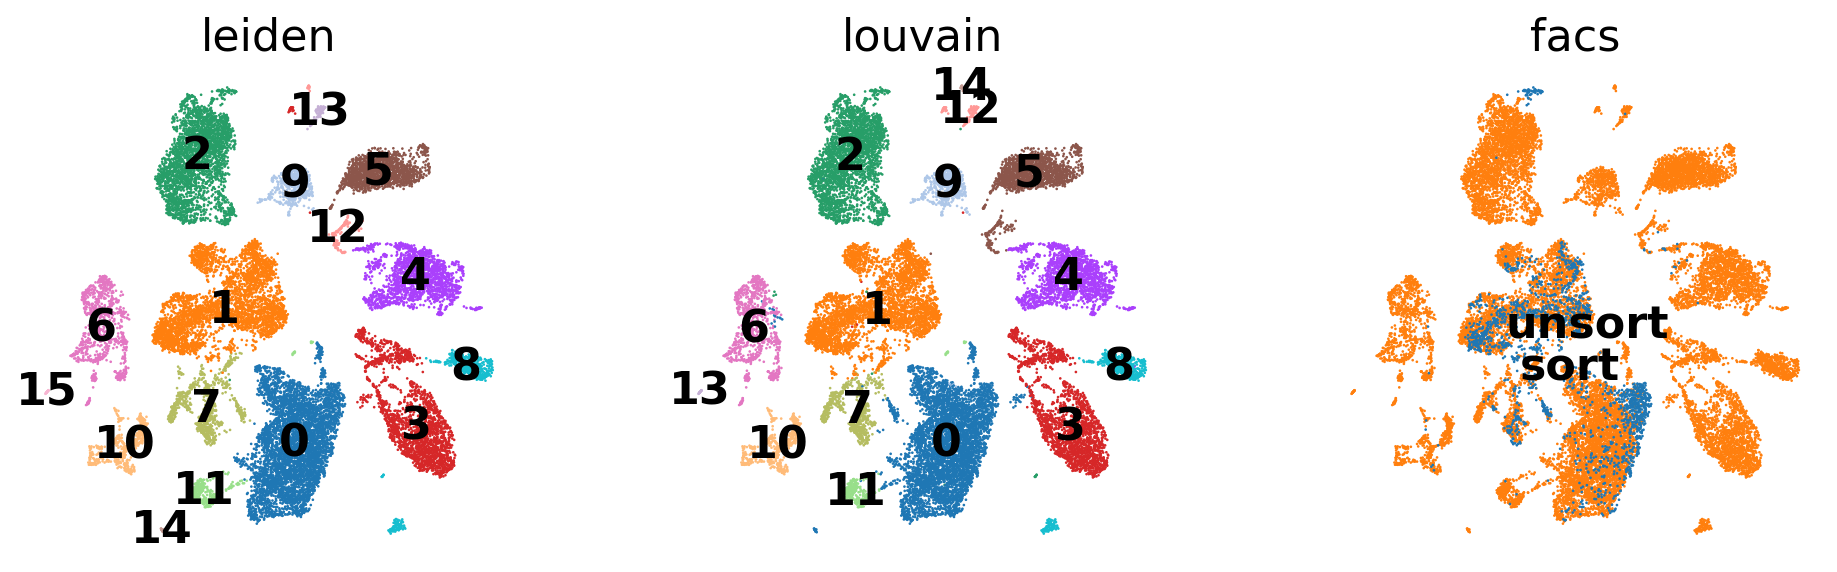

In [33]:
sc.pl.umap(adata, color=['leiden','louvain','facs'],use_raw=False,legend_loc='on data')

# merge clusters, corase clustering

In [44]:

adata.obs['leiden_number'] = adata.obs['leiden']
adata.obs['leiden_coarse'] = adata.obs['leiden_number']

old_to_new = {'0':'Excitatory','1':'Excitatory','7':'Excitatory','11':'Excitatory','14':'Excitatory',
              '2': 'Microglia', '3':'Endo','8':'Endo','4':'Oligo', '5':'OPC','12':'OPC',
              '6': 'Inhibitory','10':'Inhibitory','9':'Astro',
              '13':'Act.Microglia','15':'Endo'}
    
adata.obs['leiden_coarse'] = (
    adata.obs['leiden_number']
    .map(old_to_new)
    .astype('category')
)

In [52]:
adata.obs['leiden_coarse'].value_counts()

Excitatory       10005
Microglia         2951
Endo              2741
OPC               1780
Oligo             1778
Inhibitory        1425
Astro              496
Act.Microglia       85
Name: leiden_coarse, dtype: int64

In [53]:
adata.obs['leiden_coarse'].cat.categories

Index(['Act.Microglia', 'Astro', 'Endo', 'Excitatory', 'Inhibitory',
       'Microglia', 'OPC', 'Oligo'],
      dtype='object')

In [55]:
adata.obs['leiden_coarse'].cat.reorder_categories(['Excitatory','Microglia', 'Endo',
                                                    'OPC','Oligo','Inhibitory',
                                                    'Astro','Act.Microglia'], inplace = True)

In [72]:
## extract cluster color code
adata.uns['leiden_coarse_colors']

['#1f77b4',
 '#aec7e8',
 '#ff7f0e',
 '#ffbb78',
 '#2ca02c',
 '#98df8a',
 '#d62728',
 '#ff9896']

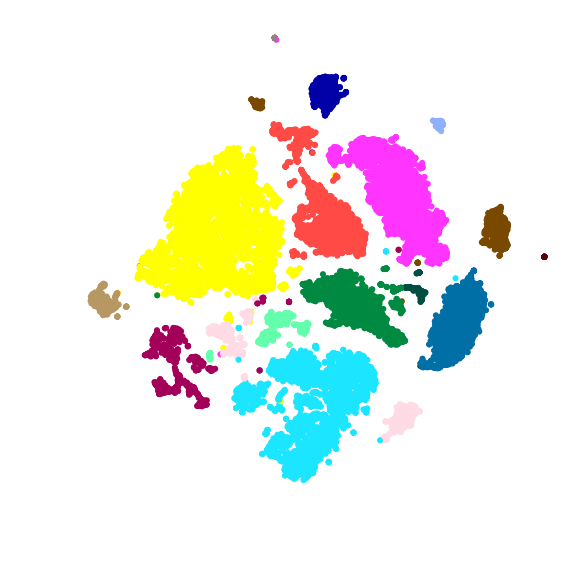

In [32]:
sc.settings.set_figure_params(dpi=80, frameon=False,fontsize=20,dpi_save=300,format='pdf')  # low dpi (dots per inch) yields small inline figures
plt.rcParams['font.sans-serif']=['Arial']
plt.rcParams['pdf.fonttype'] = 'truetype'
sc.pl.tsne(adata, color=['leiden'],title='',palette=sc.pl.palettes.godsnot_64,legend_loc='',
           size=30,save=' tsne schematics for fig1.pdf'
          )

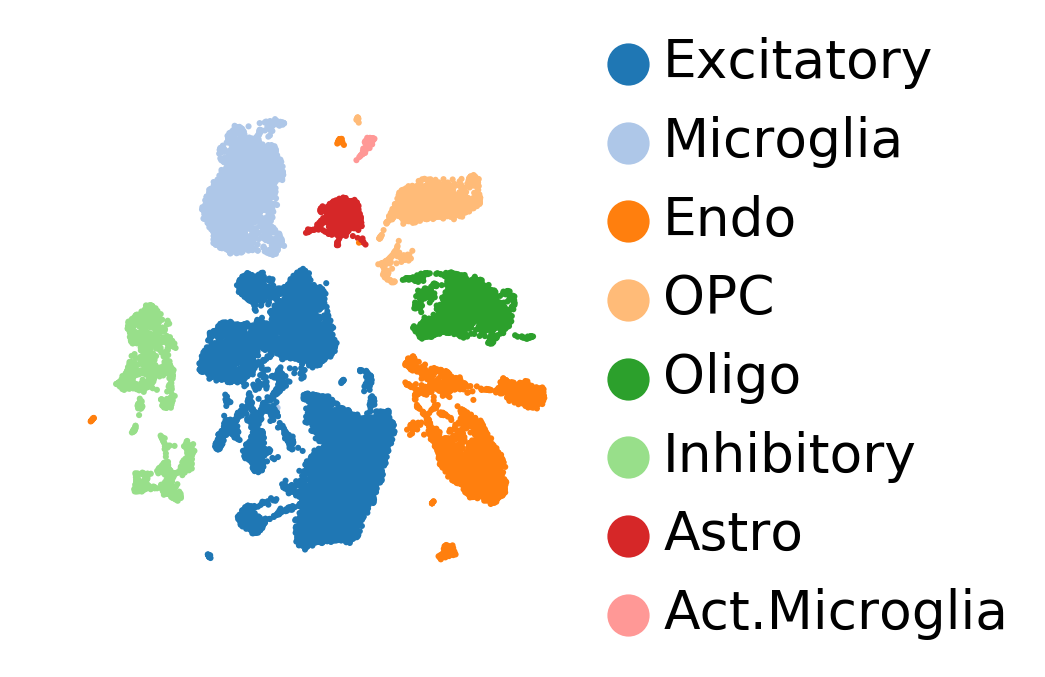

In [20]:
rcParams["legend.markerscale"] = 3.0
sc.pl.umap(adata, color=['leiden_coarse'],title='',
           legend_fontsize ='large',
           size=30,palette=sc.pl.palettes.vega_20,save=' all cell leiden corase clustering.pdf')

In [34]:
## manually change 
adata.uns['facs_colors']=['limegreen','grey']

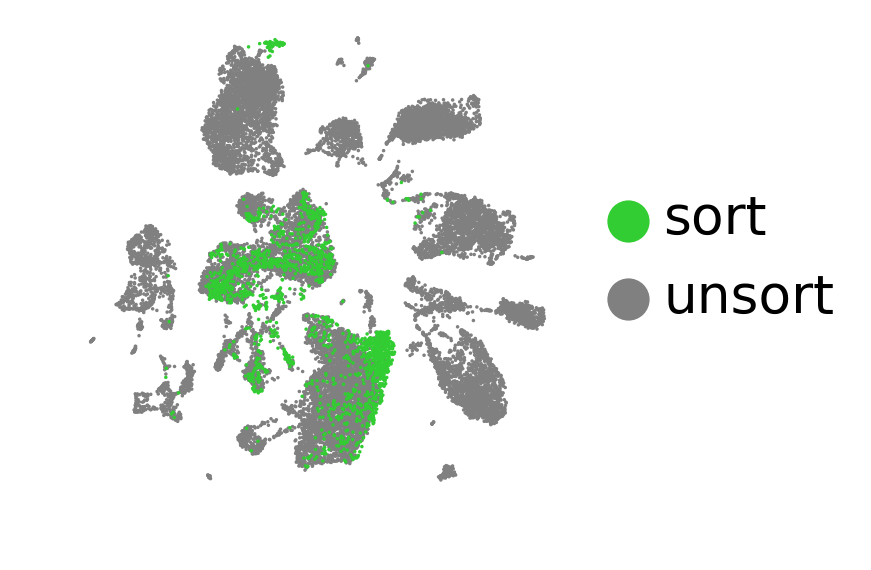

In [36]:
rcParams["legend.markerscale"] = 3.0
sc.pl.umap(adata, color=['facs'],title='',
           legend_fontsize ='large',
           size=10,save=' all cell facs cluster.pdf'
          )

In [63]:
results_file = './write/pfc_seurat_merge_anno.h5ad'
adata.write(results_file)

In [6]:
adata=sc.read_h5ad( './write/pfc_seurat_merge_anno.h5ad')

In [37]:
# export meta info
adata.obs.to_csv('pfc_seurat_merge_meta.csv')

In [7]:
adata

AnnData object with n_obs × n_vars = 21261 × 20595 
    obs: 'ClusterID', 'ClusterName', 'facs', 'nCount_RNA', 'nFeature_RNA', 'orig_ident', 'percent_mt', 'percent_rp', 'sample', 'louvain', 'leiden', 'leiden_number', 'leiden_coarse'
    var: 'Selected', 'vst_mean', 'vst_variable', 'vst_variance', 'vst_variance_expected', 'vst_variance_standardized', 'highly_variable'
    uns: 'facs_colors', 'leiden', 'leiden_coarse_colors', 'leiden_colors', 'leiden_number_colors', 'louvain', 'louvain_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'pca_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'norm_data', 'scale_data'

In [39]:
meta_valid_barcoded=pd.read_csv('/home/xupb/scRNA_data/mouse_pfc/manuscripts/scanpy/pfc_all_meta_barcoded.csv',
                       index_col=0)

In [40]:
meta_valid_barcoded['barcoded'].value_counts()

Unbarcoded    17322
Barcoded       3939
Name: barcoded, dtype: int64

In [16]:
bdata=adata.copy()

In [17]:
bdata.obs=meta_valid_barcoded

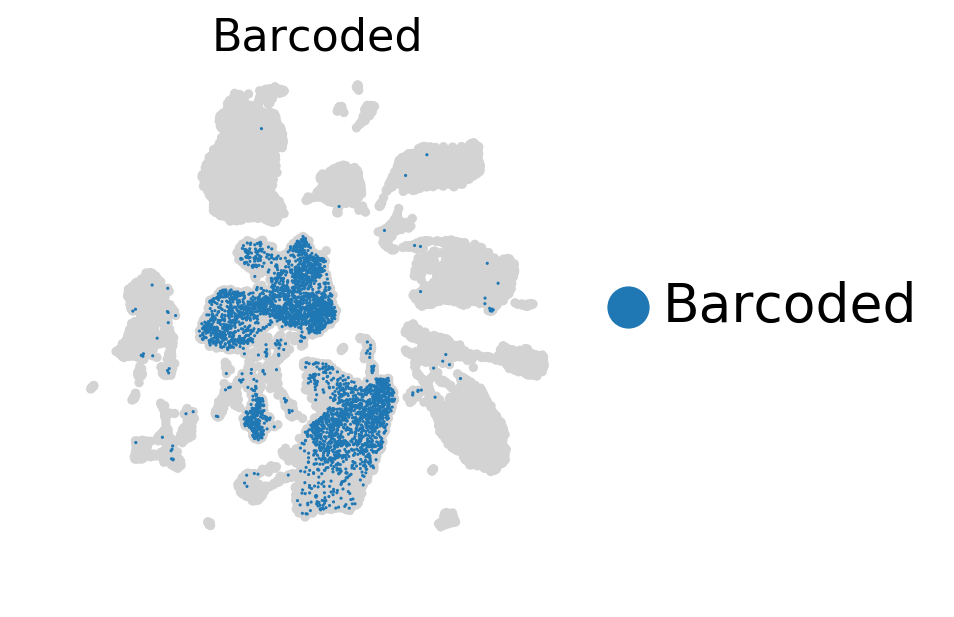

In [43]:
ax = sc.pl.umap(bdata, size=70, show=False)
rcParams["legend.markerscale"] = 3.0

sc.pl.umap(
    bdata[bdata.obs["barcoded"] == "Barcoded"],
    size=8,
    color='barcoded',title='Barcoded',legend_fontsize ='large',
    ax=ax,
    save=' all valid cells.pdf'
)


In [68]:
plt.rcParams['font.sans-serif']=['Helvetica']

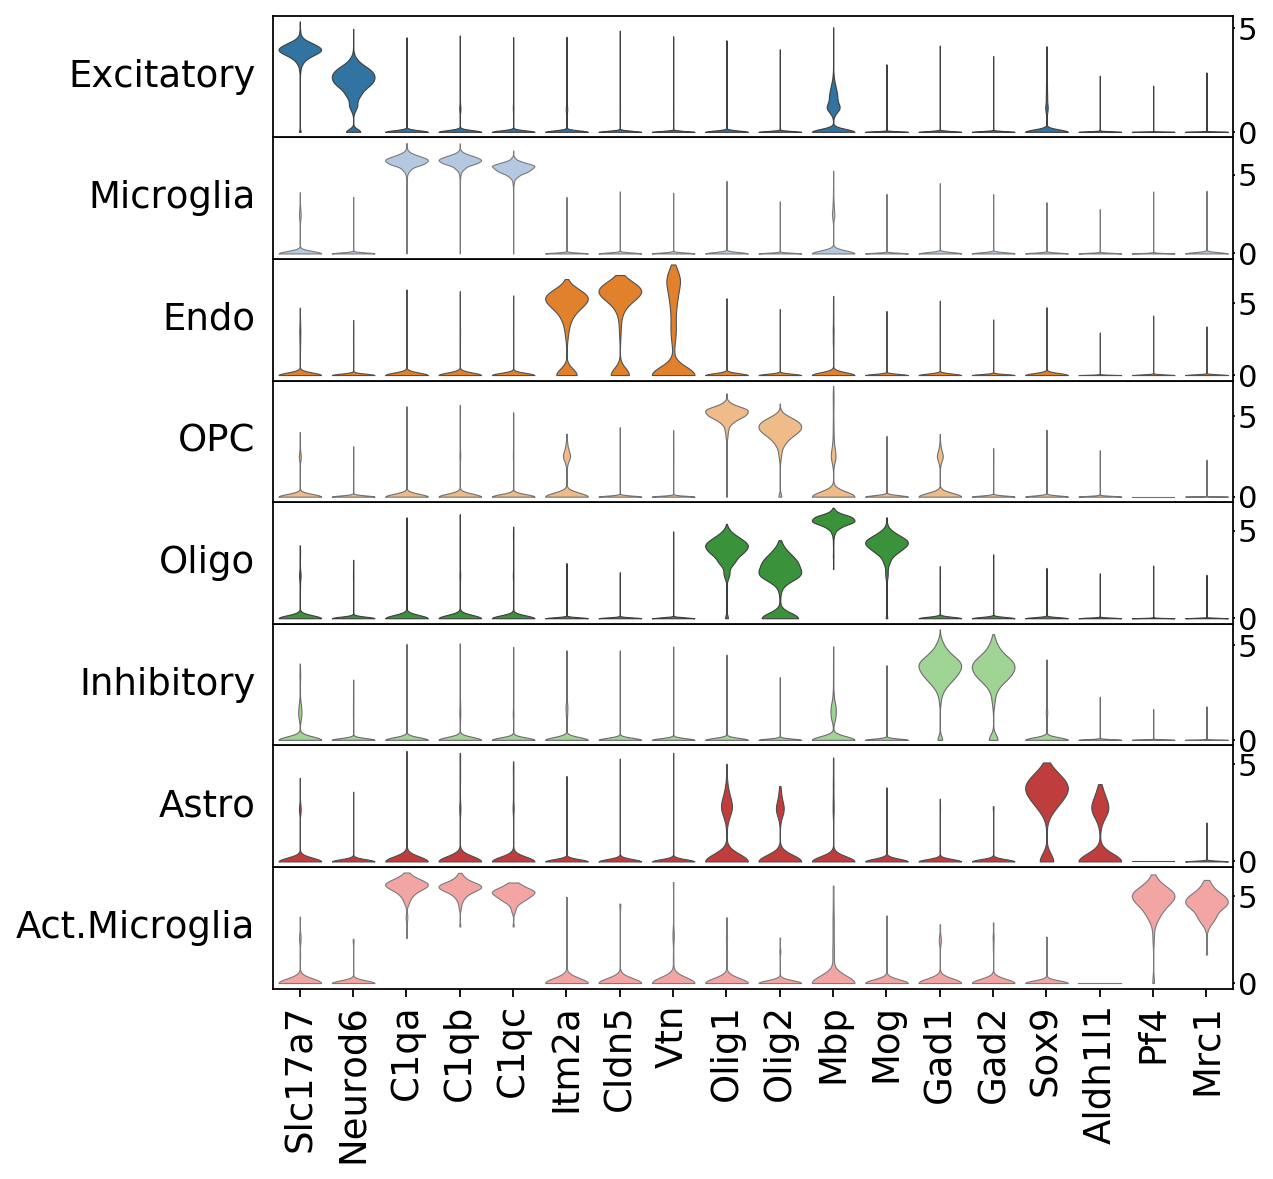

In [88]:
## violin plot of cell type markers
marker_genes=["Slc17a7",'Neurod6',
               'C1qa','C1qb','C1qc',
              'Itm2a','Cldn5',#endothelial cell
              'Vtn',# smooth muscle cell Slc6a20a
            "Olig1",'Olig2', 'Mbp','Mog',
               "Gad1",'Gad2',
            'Sox9','Aldh1l1',# Astrocyte
               'Pf4','Mrc1'
             ]
sc.pl.stacked_violin(adata, marker_genes,layer='norm_data',
                          figsize=(8,8),row_palette=sc.pl.palettes.vega_20,
                     swap_axes=False,
                          groupby='leiden_coarse',save='violin all cluster markers.pdf')